
## Maya Ghai

## INF2178

## March 9, 2024


## Set Up

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

# Read file
filename = 'INF2178_A2_data.xlsx'
df = pd.read_excel(filename)
# Select relevant columns from the DataFrame
childCareEntire = df.loc[:, ['LOC_NAME','AUSPICE','IGSPACE','TGSPACE','PGSPACE','KGSPACE','SGSPACE','TOTSPACE','subsidy','cwelcc_flag']].copy()


In [2]:
childCareEntire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   LOC_NAME     1063 non-null   object
 1   AUSPICE      1063 non-null   object
 2   IGSPACE      1063 non-null   int64 
 3   TGSPACE      1063 non-null   int64 
 4   PGSPACE      1063 non-null   int64 
 5   KGSPACE      1063 non-null   int64 
 6   SGSPACE      1063 non-null   int64 
 7   TOTSPACE     1063 non-null   int64 
 8   subsidy      1063 non-null   object
 9   cwelcc_flag  1063 non-null   object
dtypes: int64(6), object(4)
memory usage: 83.2+ KB


# Data Cleaning

In [3]:
# Renaming Age Groups
column_mapping = {
    'IGSPACE': 'Infants 0-18 months',
    'TGSPACE': 'Toddlers 18-30 months',
    'PGSPACE': '30 months up to grade one',
    'KGSPACE': 'Full-day kindergarten',
    'SGSPACE': 'Children grade one and up'
}

childCareEntire.rename(columns=column_mapping, inplace=True)

# Combine 'PGSPACE' and 'KGSPACE' into a single column
childCareEntire['Preschool and Kindergarten'] = childCareEntire['30 months up to grade one'] + childCareEntire['Full-day kindergarten']
# Drop the individual 'PGSPACE' and 'KGSPACE' columns
childCareEntire.drop(['30 months up to grade one', 'Full-day kindergarten'], axis=1, inplace=True)

# Renaming Auspices
childCareEntire.rename(columns=column_mapping, inplace=True)
mapping_auspice = {
    'Non Profit Agency': 'Non Profit',
    'Commercial Agency': 'Commercial',
    'Public (City Operated) Agency': 'Public'
}
childCareEntire['AUSPICE'] = childCareEntire['AUSPICE'].map(mapping_auspice)

Filter to find rows to remove, according to our specifications (subsidy = Y, cwelcc = N)

In [27]:
# Show subset of rows recieving subsidies not registered under the cwelcc
filtered_rows1 = childCareEntire[(childCareEntire['subsidy'] == 'Y') & (childCareEntire['cwelcc_flag'] == 'N')]
filtered_rows1

,LOC_NAME,AUSPICE,Infants 0-18 months,Toddlers 18-30 months,Children grade one and up,TOTSPACE,subsidy,cwelcc_flag,Preschool and Kindergarten
27,Early Adventures Nursery School & Child Care,Commercial,0,15,30,95,Y,N,50
31,Educare Kindergarten - Rathburn,Commercial,0,10,30,64,Y,N,24
83,Kingsview Child Care,Commercial,20,15,24,99,Y,N,40
101,Vincent Massey Academy - (521909 Ontario Ltd.),Commercial,0,45,0,93,Y,N,48
120,Educare Kindergarten - Islington,Commercial,0,10,30,90,Y,N,50
232,Williamson Road Day Care Centre,Non Profit,0,0,90,116,Y,N,26
363,Trinity Bellwoods Community Children's Group/C...,Non Profit,0,0,39,39,Y,N,0
385,Maurice Cody Child Care,Non Profit,0,0,285,402,Y,N,117
421,St. George's School Age Child Care Programme,Non Profit,0,0,60,86,Y,N,26
427,Lambton - Kingsway B & After School Program,Non Profit,0,0,105,144,Y,N,39


In [6]:
# Creating new subsets of the data based on the filter
cwelcc = childCareEntire[childCareEntire['cwelcc_flag'] == 'Y'] # Part of the CWELCC
subsidizedCwelcc = cwelcc[cwelcc['subsidy']=='Y'] # Recieving Subsidy in the CWELCC

# Defining Functions Used:

In [9]:
def get_summary_statistics(dataset, dataset_name):
    '''
    Calculate and display summary statistics for a given dataset.

    Parameters:
    - dataset (pandas.Series): The dataset for which summary statistics are calculated.
    - dataset_name (str): The name of the dataset.

    Returns:
    - Summary Table: Displays the summary statistics table.
    '''

    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.median(dataset), 2)
    sd = np.round(np.std(dataset),2)

    # Calculate IQR
    q1 = np.percentile(dataset, 25)
    q3 = np.percentile(dataset, 75)
    iqr = np.round(q3 - q1, 2)

    # Create a formatted table
    summary_table = pd.DataFrame({
        'Statistic': ['Mean', 'Median','Standard Deviation','IQR'],
        'Value': [mean, median, sd, iqr]})
    summary_table.set_index(keys=summary_table['Statistic'],inplace=True)
    summary_table.drop(columns='Statistic',inplace=True)
    return summary_table


In [105]:

def categorical_boxplot(dataset, categorical_column, quantitative_columns):
    """
    Create a visualization with color-coded boxplots for each level of the categorical variable.

    Parameters:
    - dataset (pd.DataFrame): The dataset containing the data.
    - categorical_column (str): The column name of the categorical variable.
    - quantitative_columns (list(str)): A list containing column names of the quantitative variables.

    Returns:
    - None: Displays the color-coded boxplots.
    """
    # Melt the dataset for a catplot
    melted_data = pd.melt(dataset, id_vars=[categorical_column], value_vars=quantitative_columns)

    # Create a catplot using seaborn
    g = sns.catplot(x=categorical_column, y="value", hue="variable", data=melted_data, kind="box", aspect=2.5, palette=sns.color_palette('Set2', len(quantitative_columns)))

    # Set axis labels
    g.set_axis_labels(x_var=categorical_column,y_var='Spaces Available')

    # Show the plot
    plt.show()


In [30]:
# Define a List of Quantiative Column Names
global quantitative_columns
quantitative_columns = [
    'Infants 0-18 months',
    'Toddlers 18-30 months',
    'Preschool and Kindergarten',
    'Children grade one and up'
]

# Output

## EDA

<Axes: title={'center': 'TOTSPACE'}, ylabel='Frequency'>

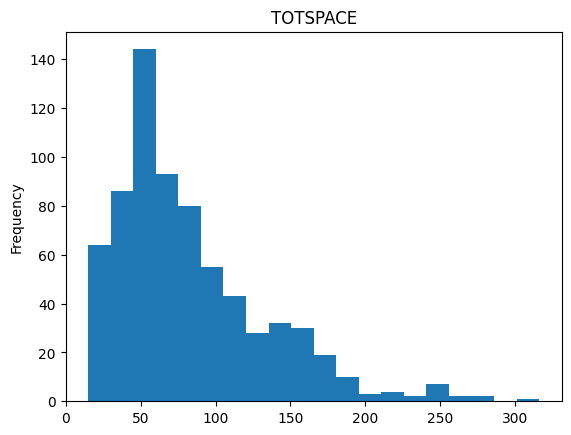

In [29]:
subsidizedCwelcc['TOTSPACE'].plot(kind='hist', bins=20, title='TOTSPACE',hue=[])

In [28]:
subsidizedCwelcc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 1061
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LOC_NAME                    705 non-null    object
 1   AUSPICE                     705 non-null    object
 2   Infants 0-18 months         705 non-null    int64 
 3   Toddlers 18-30 months       705 non-null    int64 
 4   Children grade one and up   705 non-null    int64 
 5   TOTSPACE                    705 non-null    int64 
 6   subsidy                     705 non-null    object
 7   cwelcc_flag                 705 non-null    object
 8   Preschool and Kindergarten  705 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 55.1+ KB


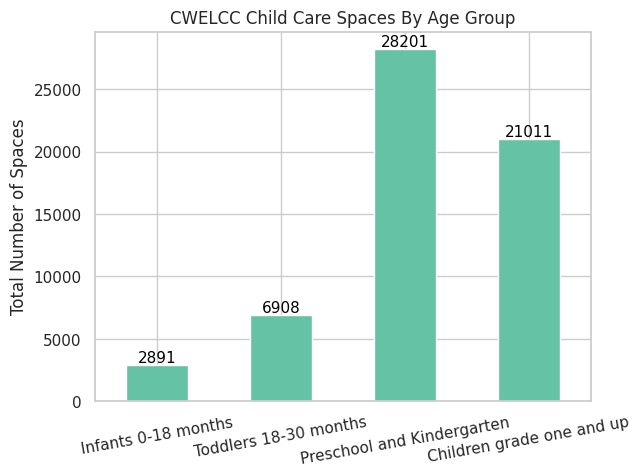

In [126]:

ax = subsidizedCwelcc[quantitative_columns].sum().plot(kind='bar',colormap='Set2', rot=10)

# Displaying the total count on top of each bar
ax.bar_label(ax.containers[0], label_type='edge', fontsize=11, color='black')

ax.set_ylabel('Total Number of Spaces')
ax.set_title('CWELCC Child Care Spaces By Age Group')
plt.show()

quantitative_columns = [
    'Infants 0-18 months',
    'Toddlers 18-30 months',
    'Preschool and Kindergarten',
    'Children grade one and up'
]


<Figure size 400x300 with 0 Axes>

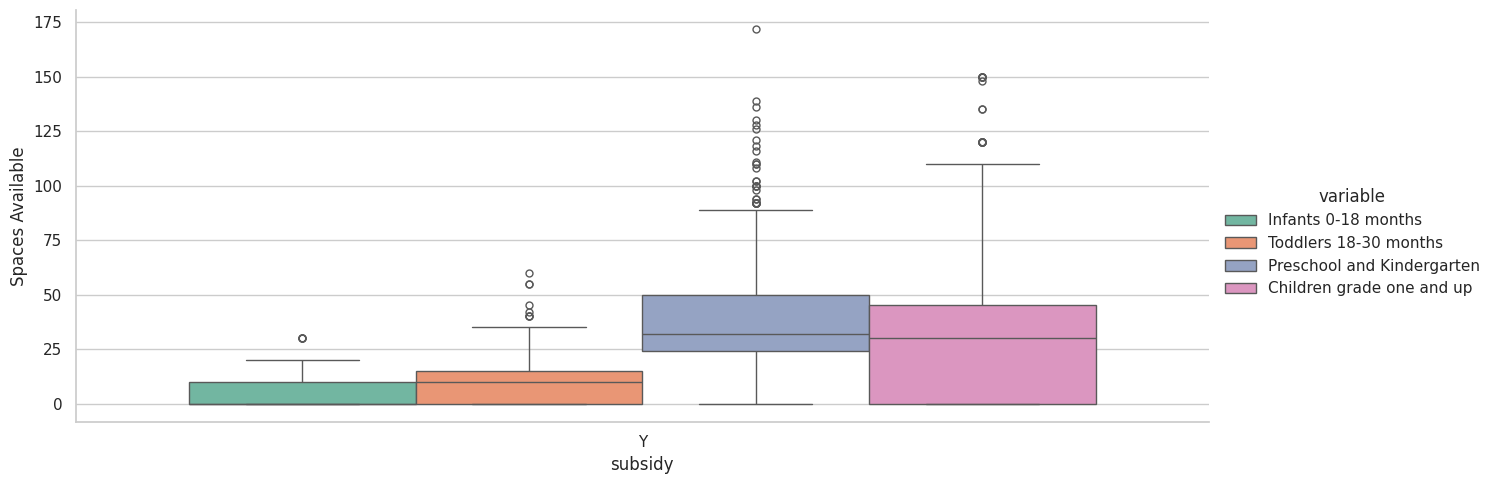

In [104]:
plt.figure(figsize=(4, 3))
categorical_boxplot(subsidizedCwelcc, 'subsidy', quantitative_columns)


In [32]:
round(subsidizedCwelcc[quantitative_columns].describe(),2)

,Infants 0-18 months,Toddlers 18-30 months,Preschool and Kindergarten,Children grade one and up
count,705.00,705.00,705.00,705.00
mean,4.10,9.80,40.00,29.80
std,5.92,9.92,25.45,31.41
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,24.00,0.00
50%,0.00,10.00,32.00,30.00
75%,10.00,15.00,50.00,45.00
max,30.00,60.00,172.00,150.00


## **ONE WAY ANOVA**

### ASSUMPTION CHECKING

> 1 - Check if each age group variable follows a normal distribution

> 2 - Assess whether variances are approximately equal








In [127]:
from scipy.stats import shapiro, levene


# Check for normality using Shapiro-Wilk test
for column in quantitative_columns:
    stat, p_value = shapiro(subsidizedCwelcc[column])
    print(f"Shapiro-Wilk test p-value for {column}: {p_value:.3f}")

# Check for homoscedasticity using Levene's test
levene_stat, levene_p_value = levene(
    subsidizedCwelcc['Infants 0-18 months'],
    subsidizedCwelcc['Toddlers 18-30 months'],
    subsidizedCwelcc['Preschool and Kindergarten'],
    subsidizedCwelcc['Children grade one and up']
)
print("\nLevene's test for homoscedasticity:")
print(f"Levene's test statistic: {levene_stat:.3f}")
print(f"Levene's test p-value: {levene_p_value:.3f}")

alpha = 0.05
if levene_p_value < alpha:
    print('The test result is significant, suggesting non-homogeneity of variances.')

Shapiro-Wilk test p-value for Infants 0-18 months: 0.000
Shapiro-Wilk test p-value for Toddlers 18-30 months: 0.000
Shapiro-Wilk test p-value for Preschool and Kindergarten: 0.000
Shapiro-Wilk test p-value for Children grade one and up: 0.000

Levene's test for homoscedasticity:
Levene's test statistic: 286.065
Levene's test p-value: 0.000
The test result is significant, suggesting non-homogeneity of variances.


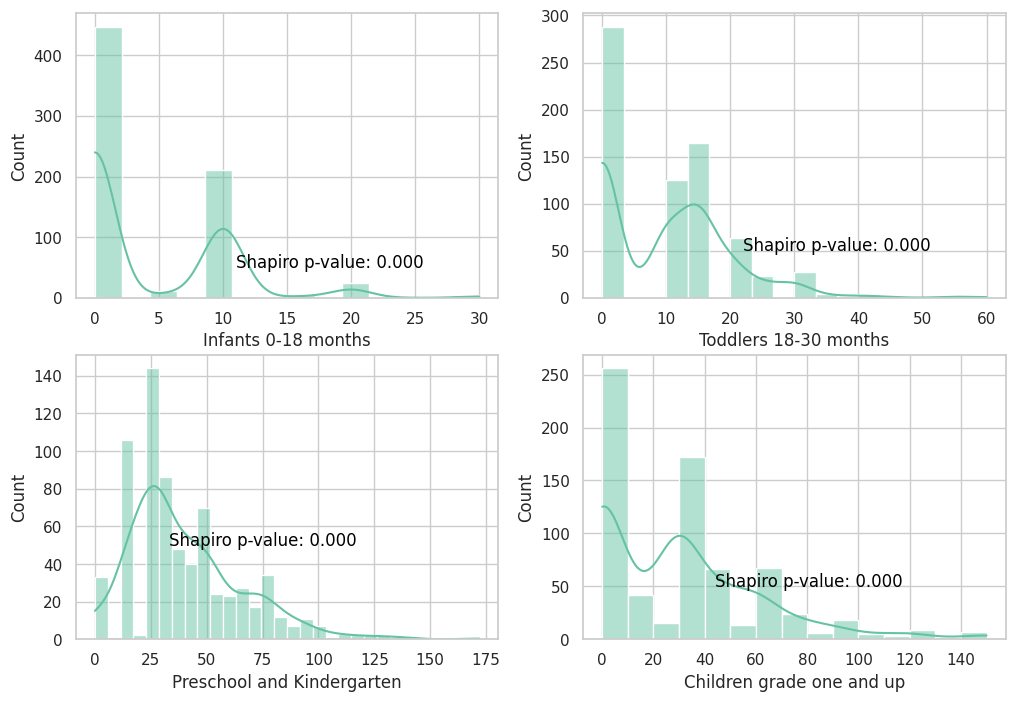

In [121]:
from scipy.stats import shapiro

plt.figure(figsize=(12, 17))

for i, space in enumerate(quantitative_columns, 1):

    plt.subplot(len(quantitative_columns),2,i)
    sns.histplot(x=subsidizedCwelcc[space], kde=True)

    # Shapiro-Wilk test for normality
    stats_value, p_value = shapiro(subsidizedCwelcc[space])
    plt.text(i+(i*10),50,f'Shapiro p-value: {p_value:.3f}',color='black')


plt.show()

### Run One Way ANOVA

In [128]:
from scipy.stats import f_oneway
# Perform one-way ANOVA on quantitative columns
results = [f_oneway(
    subsidizedCwelcc['Infants 0-18 months'],
    subsidizedCwelcc['Toddlers 18-30 months'],
    subsidizedCwelcc['Preschool and Kindergarten'],
    subsidizedCwelcc['Children grade one and up'],
)]

print(results)

[F_onewayResult(statistic=451.7170775028818, pvalue=1.3978850450257853e-239)]


In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

data_long = pd.melt(subsidizedCwelcc, value_vars=quantitative_columns)
# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(data_long['value'], data_long['variable'], alpha=0.05)

#Print Tukey's HSD results
print("\nTukey's HSD Results:")
print(tukey_results)


Tukey's HSD Results:
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                     
          group1                     group2           meandiff p-adj  lower    upper   reject
---------------------------------------------------------------------------------------------
 Children grade one and up        Infants 0-18 months -25.7021   0.0 -28.5805 -22.8237   True
 Children grade one and up Preschool and Kindergarten  10.1986   0.0   7.3202   13.077   True
 Children grade one and up      Toddlers 18-30 months -20.0043   0.0 -22.8827 -17.1258   True
       Infants 0-18 months Preschool and Kindergarten  35.9007   0.0  33.0223  38.7791   True
       Infants 0-18 months      Toddlers 18-30 months   5.6979   0.0   2.8195   8.5763   True
Preschool and Kindergarten      Toddlers 18-30 months -30.2028   0.0 -33.0812 -27.3244   True
---------------------------------------------------------------------------------------------


## **TWO WAY ANOVA**

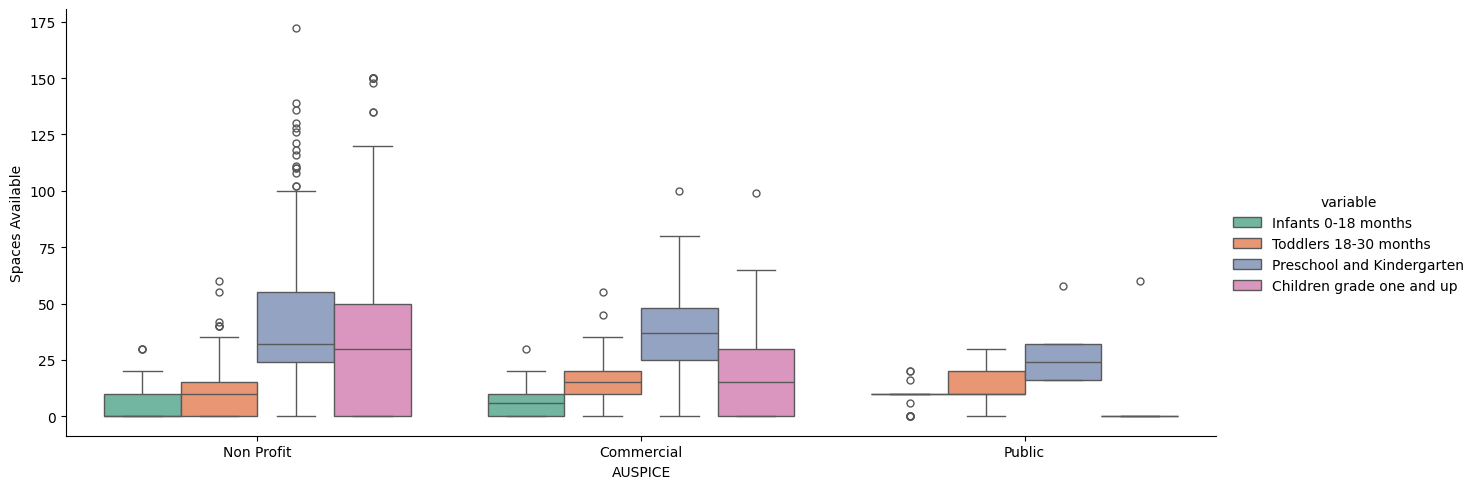

In [20]:
quantitative_columns
categorical_boxplot(subsidizedCwelcc, 'AUSPICE', quantitative_columns)

In [21]:
from scipy.stats import shapiro, levene

# Check for normality using Shapiro-Wilk test
for column in subsidizedCwelcc['AUSPICE'].unique():
    stat, p_value = shapiro(subsidizedCwelcc['AUSPICE']==column)
    print(f"Shapiro-Wilk test p-value for {column}: {p_value:.3f}")

# Check for homoscedasticity using Levene's test
levene_stat, levene_p_value = levene(
    subsidizedCwelcc['AUSPICE']=='Non Profit',
    subsidizedCwelcc['AUSPICE']=='Commercial',
    subsidizedCwelcc['AUSPICE']=='Public',
)
print("\nLevene's test for homoscedasticity:")
print(f"Levene's test statistic: {levene_stat:.3f}")
print(f"Levene's test p-value: {levene_p_value:.3f}")



Shapiro-Wilk test p-value for Non Profit: 0.000
Shapiro-Wilk test p-value for Commercial: 0.000
Shapiro-Wilk test p-value for Public: 0.000

Levene's test for homoscedasticity:
Levene's test statistic: 19.571
Levene's test p-value: 0.000


In [22]:
melted_dataframe = pd.melt(subsidizedCwelcc, id_vars=['AUSPICE'], value_vars=quantitative_columns)

# Rename columns for consistency
melted_dataframe = melted_dataframe.rename(columns={'variable': 'AgeGroup', 'value': 'SpacesAvailable'})

# Fit the two-way ANOVA model
formula = 'SpacesAvailable ~ C(AUSPICE) * C(AgeGroup)'
model = ols(formula, data=melted_dataframe).fit()
anova_table = (sm.stats.anova_lm(model, typ=2))

# Display the ANOVA table
print("\nTwo-Way ANOVA Results:")
anova_table


Two-Way ANOVA Results:


,sum_sq,df,F,PR(>F)
C(AUSPICE),1.440258e+04,2.0,17.151707,3.946756e-08
C(AgeGroup),5.989537e+05,3.0,475.520316,7.958951e-250
C(AUSPICE):C(AgeGroup),5.125873e+04,6.0,20.347625,1.985942e-23
Residual,1.178963e+06,2808.0,NaN,NaN


In [23]:
# Perform post hoc tests (Tukey's HSD)
posthoc = pairwise_tukeyhsd(melted_dataframe['SpacesAvailable'], melted_dataframe['AUSPICE'] + '_' + melted_dataframe['AgeGroup'], alpha=0.05)

# Display post hoc results
print("\nPost Hoc Test Results:")
print(posthoc)


Post Hoc Test Results:
                                Multiple Comparison of Means - Tukey HSD, FWER=0.05                                 
                group1                                group2                meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------------------------------------------------
 Commercial_Children grade one and up        Commercial_Infants 0-18 months -11.1127 0.0564  -22.361   0.1357  False
 Commercial_Children grade one and up Commercial_Preschool and Kindergarten  21.3521    0.0  10.1037  32.6005   True
 Commercial_Children grade one and up      Commercial_Toddlers 18-30 months  -1.8169    1.0 -13.0653   9.4315  False
 Commercial_Children grade one and up  Non Profit_Children grade one and up  15.6156    0.0   7.2007  24.0306   True
 Commercial_Children grade one and up        Non Profit_Infants 0-18 months -14.0028    0.0 -22.4178  -5.5879   True
 Commercial_Children grade one and up No

In [24]:
# Group by 'AUSPICE', calculating average count for each age group and SEM
avg_count_by_auspice = subsidizedCwelcc.groupby('AUSPICE')[quantitative_columns].agg(['mean', 'sem'])

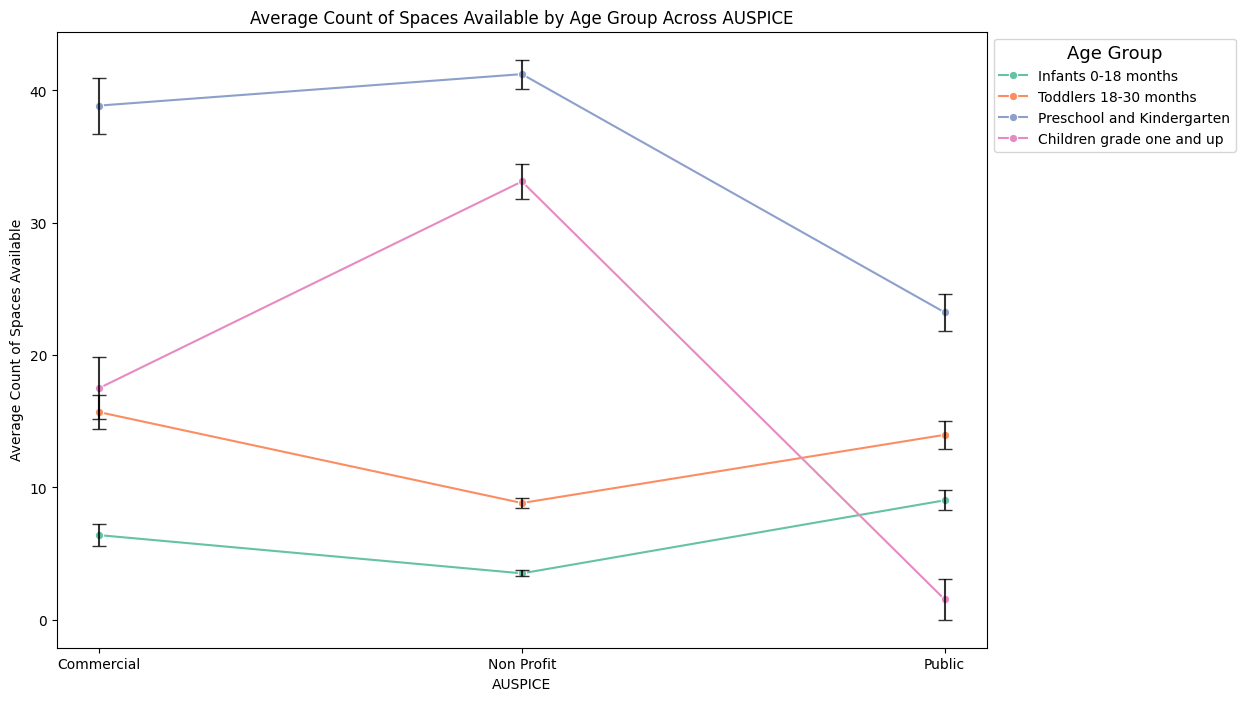

In [25]:
# Define the colors from 'Set2' palette
colors = sns.color_palette('Set2')

# Plot the results
plt.figure(figsize=(12, 8))
sns.lineplot(x=avg_count_by_auspice.index, y=avg_count_by_auspice[('Infants 0-18 months', 'mean')], marker='o', label='Infants 0-18 months', color=colors[0])
sns.lineplot(x=avg_count_by_auspice.index, y=avg_count_by_auspice[('Toddlers 18-30 months', 'mean')], marker='o', label='Toddlers 18-30 months', color=colors[1])
sns.lineplot(x=avg_count_by_auspice.index, y=avg_count_by_auspice[('Preschool and Kindergarten', 'mean')], marker='o', label='Preschool and Kindergarten', color=colors[2])
sns.lineplot(x=avg_count_by_auspice.index, y=avg_count_by_auspice[('Children grade one and up', 'mean')], marker='o', label='Children grade one and up', color=colors[3])

# Add error bars for SEM
for i, column in enumerate(quantitative_columns):
    plt.errorbar(x=avg_count_by_auspice.index,
                 y=avg_count_by_auspice[(column, 'mean')],
                 yerr=avg_count_by_auspice[(column, 'sem')],
                 linestyle='None', capsize=5, color='black', alpha=.8)

# Add labels and title
plt.xlabel('AUSPICE')
plt.ylabel('Average Count of Spaces Available')
plt.title('Average Count of Spaces Available by Age Group Across AUSPICE')

# Add legend
plt.legend(title='Age Group', title_fontsize='13', bbox_to_anchor=(1, 1), loc='upper left')

# Show the plot
plt.show()